## Import and setup

In [1]:
import logging

# Logging config must be imported before utils...
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    # filename = "logger.log",
)

import random
import warnings

import numpy as np
import torch
import jupyter_black

import models_HMPNN_sum, models_HMPNN_ct, utils

jupyter_black.load()

# Ignoring UserWarnings
warnings.simplefilter("ignore", UserWarning)

# Setting random state seeds
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

## Load Data

In [2]:
from torch_geometric.datasets import IMDB
import torch_geometric.transforms as T

transform = T.ToUndirected()  # Add reverse edge types.
data = IMDB(root="./data/IMDB/", transform=transform)[0]

# Making the classification problem binary by merging class 2 and 1
data["movie"].y[data["movie"].y == 2] = 1

# Add edge attributes to all edges. The model expects edge attributes, and will produce error if it does not exist.
for edge_type in data.edge_types:
    data[edge_type].edge_attr = torch.ones(
        [data[edge_type].edge_index.shape[1], 1], dtype=torch.float32
    )

# Reducing the number of node features by removing those that are most frequently equal to zero
feature_mask = (data["movie"].x != 0).sum(dim=0) > 150
data["movie"].x = data["movie"].x[:, feature_mask]

feature_mask = (data["director"].x != 0).sum(dim=0) > 150
data["director"].x = data["director"].x[:, feature_mask]

feature_mask = (data["actor"].x != 0).sum(dim=0) > 400
data["actor"].x = data["actor"].x[:, feature_mask]

# Casting the reponse variable to float and reshaping it to match the exepcted dimension
data["movie"].y = data["movie"].y.reshape([len(data["movie"].y), 1]).to(torch.float32)

# Creating (new) train/validation/test splits (The original one has a very large test-set)
(
    data["movie"].train_mask,
    data["movie"].val_mask,
    data["movie"].test_mask,
) = utils.train_val_test_split(0.2, 0.2, data["movie"].y[:, 0])

## Set training parameters 

In [7]:
node_type_to_classify = "movie"
learning_rate = 1e-3
weight_decay = 1e-5  # Regularization Strength (Use L2 regularization)
min_epochs = 1_000
max_epochs = 10_000
print_learning_progress_freq = 50

## Training HMPNN_sum Model

2024-04-11 19:28:12 INFO Number of model params: 5,340
2024-04-11 19:28:12 INFO Epoch #0. Validation loss: 1.4568
2024-04-11 19:28:14 INFO Epoch #50. Validation loss: 0.6024
2024-04-11 19:28:16 INFO Epoch #100. Validation loss: 0.5545
2024-04-11 19:28:17 INFO Epoch #150. Validation loss: 0.5431
2024-04-11 19:28:19 INFO Epoch #200. Validation loss: 0.5363
2024-04-11 19:28:21 INFO Epoch #250. Validation loss: 0.5353
2024-04-11 19:28:23 INFO Epoch #300. Validation loss: 0.5338
2024-04-11 19:28:25 INFO Epoch #350. Validation loss: 0.5314
2024-04-11 19:28:26 INFO Epoch #400. Validation loss: 0.5284
2024-04-11 19:28:28 INFO Epoch #450. Validation loss: 0.5266
2024-04-11 19:28:30 INFO Epoch #500. Validation loss: 0.5277
2024-04-11 19:28:32 INFO Epoch #550. Validation loss: 0.5326
2024-04-11 19:28:34 INFO Epoch #600. Validation loss: 0.5425
2024-04-11 19:28:35 INFO Epoch #650. Validation loss: 0.5550
2024-04-11 19:28:37 INFO Epoch #700. Validation loss: 0.5658
2024-04-11 19:28:39 INFO Epoch #7

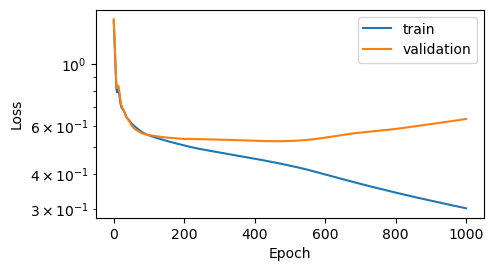

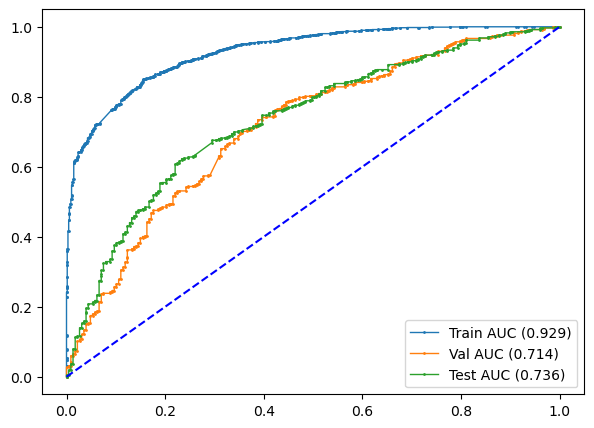

In [8]:
# Initialize model
model = models_HMPNN_sum.HMPNN_sum_3Layer(data, node_type_to_classify)
logging.info(f"Number of model params: {utils.get_num_params_of_model(model):,}")

# Train Model
model, train_hist = utils.train_model(
    model,
    data,
    node_type_to_classify,
    learning_rate,
    weight_decay,
    min_epochs,
    max_epochs,
    print_learning_progress_freq,
)

# Plot Results
utils.plot_training_hist(train_hist)

# Use the trained model to make predictions 
with torch.no_grad():
    pred = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

utils.plot_roc_curves(data, pred, node_type_to_classify)

## Training models_HMPNN_ct Model

2024-04-11 19:28:48 INFO Number of model params: 5,291
2024-04-11 19:28:48 INFO Epoch #0. Validation loss: 0.6083
2024-04-11 19:28:50 INFO Epoch #50. Validation loss: 0.5781
2024-04-11 19:28:52 INFO Epoch #100. Validation loss: 0.5770
2024-04-11 19:28:54 INFO Epoch #150. Validation loss: 0.5749
2024-04-11 19:28:56 INFO Epoch #200. Validation loss: 0.5690
2024-04-11 19:28:57 INFO Epoch #250. Validation loss: 0.5483
2024-04-11 19:28:59 INFO Epoch #300. Validation loss: 0.5272
2024-04-11 19:29:01 INFO Epoch #350. Validation loss: 0.5216
2024-04-11 19:29:03 INFO Epoch #400. Validation loss: 0.5201
2024-04-11 19:29:05 INFO Epoch #450. Validation loss: 0.5197
2024-04-11 19:29:06 INFO Epoch #500. Validation loss: 0.5200
2024-04-11 19:29:08 INFO Epoch #550. Validation loss: 0.5215
2024-04-11 19:29:10 INFO Epoch #600. Validation loss: 0.5239
2024-04-11 19:29:12 INFO Epoch #650. Validation loss: 0.5226
2024-04-11 19:29:14 INFO Epoch #700. Validation loss: 0.5257
2024-04-11 19:29:16 INFO Epoch #7

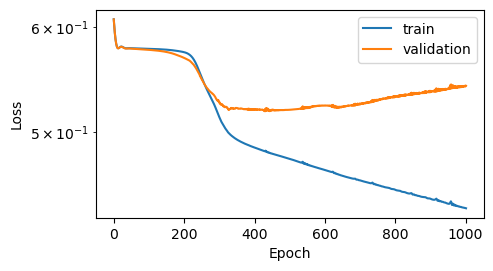

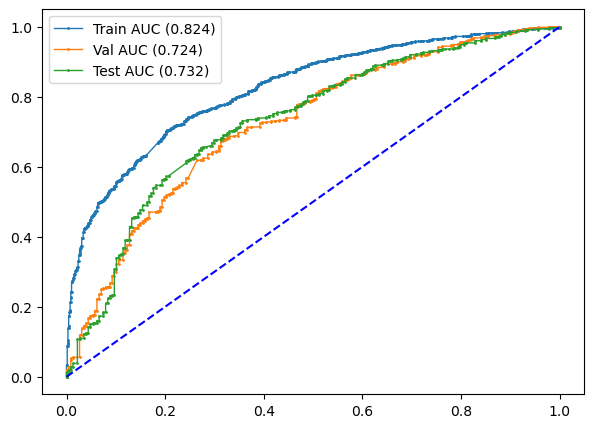

In [9]:
# Initialize model
model = models_HMPNN_ct.HMPNN_ct_3Layer(data, node_type_to_classify)
logging.info(f"Number of model params: {utils.get_num_params_of_model(model):,}")

# Train Model
model, train_hist = utils.train_model(
    model,
    data,
    node_type_to_classify,
    learning_rate,
    weight_decay,
    min_epochs,
    max_epochs,
    print_learning_progress_freq,
)

# Plot Results
utils.plot_training_hist(train_hist)

# Use the trained model to make predictions 
with torch.no_grad():
    pred = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

utils.plot_roc_curves(data, pred, node_type_to_classify)